# Analysis of NRL Data
Extension of work from http://nbviewer.jupyter.org/github/fisadev/world_cup_learning/blob/master/learn.ipynb (utility functions used are derived from previous NB) but utilising Keras and NRL data. Stll a work in progress..

## 1. Libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils

# Scikit-Learn deprecation warnings, turn off.
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 2. Data IO

We'll be using historical NRL data obtained from: http://www.aussportsbetting.com/data/ Which comes with the disclaimer "The following data set may contain errors.  It is a condition of use that you do not rely upon the information provided in this spreadsheet when making wagering decisions. Please verify everything for yourself."

We'll also use a dataset which shows the top 4 places in each year of the competition since 2009.

In [4]:
nrl_raw = pd.read_excel("nrl.xlsx", header = 1)
nrl_winners = pd.read_csv("nrl_raw_winners.csv")

## 3. Data Cleaning

Here we're going to clean the data into a more basic format, and include only the data we deem relevant for analysis.

In [6]:
nrl_raw.head(5)

,Date,Kick-off (local),Home Team,Away Team,Home Score,Away Score,Play Off Game?,Over Time?,Home Odds,Draw Odds,...,Total Score Close,Total Score Over Open,Total Score Over Min,Total Score Over Max,Total Score Over Close,Total Score Under Open,Total Score Under Min,Total Score Under Max,Total Score Under Close,Notes
0,2016-10-02,19:15:00,Melbourne Storm,Cronulla Sharks,12,14,Y,NaN,1.86,17.94,...,34.5,1.925,1.854,1.952,1.943,1.925,1.833,1.925,1.909,NaN
1,2016-09-24,19:40:00,Melbourne Storm,Canberra Raiders,14,12,Y,NaN,1.42,20.72,...,36.0,1.925,1.862,2.050,1.862,1.925,1.925,1.925,1.990,NaN
2,2016-09-23,19:55:00,Cronulla Sharks,North QLD Cowboys,32,20,Y,NaN,2.02,18.76,...,36.5,1.925,1.917,1.980,1.970,1.925,1.877,1.934,1.884,NaN
3,2016-09-17,19:40:00,Canberra Raiders,Penrith Panthers,22,12,Y,NaN,1.66,19.23,...,42.5,1.961,1.961,1.990,1.990,1.892,1.892,1.862,1.862,NaN
4,2016-09-16,19:55:00,North QLD Cowboys,Brisbane Broncos,26,20,Y,Y,1.49,20.97,...,38.0,1.925,1.925,1.970,1.943,1.925,1.925,2.000,1.909,NaN


In [5]:
nrl_df = pd.DataFrame(columns = ["year", "team1", "score1", "score2", "team2"])

In [6]:
nrl_df.year = pd.to_datetime(nrl_raw.Date)
nrl_df.year = nrl_df.year.apply(lambda x: x.year)
nrl_df.team1 = nrl_raw["Home Team"]
nrl_df.score1 = nrl_raw["Home Score"]
nrl_df.score2 = nrl_raw["Away Score"]
nrl_df.team2 = nrl_raw["Away Team"]
nrl_df.head(5)

,year,team1,score1,score2,team2
0,2016,Melbourne Storm,12,14,Cronulla Sharks
1,2016,Melbourne Storm,14,12,Canberra Raiders
2,2016,Cronulla Sharks,32,20,North QLD Cowboys
3,2016,Canberra Raiders,22,12,Penrith Panthers
4,2016,North QLD Cowboys,26,20,Brisbane Broncos


## 4. Basic Exploration
We're going to utilise some utility functions to extra out relevant information on the dataset. These functions allow us to derive out some basic match statistics.

In [21]:
def get_matches(with_team_stats=False):
    """Create a dataframe with matches info."""
    matches = nrl_df

    def winner(x):
        if x > 0:
            return 1
        elif x < 0:
            return 2
        else:
            return 0

    matches['score_diff'] = matches['score1'] - matches['score2']
    matches['winner'] = matches['score_diff']
    matches['winner'] = matches['winner'].map(winner)

    if with_team_stats:
        stats = get_team_stats()
        matches = matches.join(stats, on='team1')\
                         .join(stats, on='team2', rsuffix='_2')

    return matches

def get_team_stats():
    """Create a dataframe with useful stats for each team."""
    matches = get_matches()
    winners = nrl_winners
    
    # Find the set of all unique teams and initialise a dataframe to hold the stats we are going to calculate.
    teams = set(matches.team1.unique()).union(matches.team2.unique())
    stats = pd.DataFrame(list(teams), columns=['team'])
    stats = stats.set_index('team')

    # Iterate over each team and calculate the following statistics:
    # - Matches Won (%), Ratio of Points Scored/Points Conceded,
    # - Matches Lost, Yearly Podium Score
    for team in teams:
        team_matches = matches[(matches.team1 == team) | (matches.team2 == team)]
        stats.loc[team, 'matches_played'] = len(team_matches)

        # wins where the team was  the home side (team1)
        wins1 = team_matches[(team_matches.team1 == team) & (team_matches.score1 > team_matches.score2)]
        # wins where the team was  the away side (team2)
        wins2 = team_matches[(team_matches.team2 == team) & (team_matches.score2 > team_matches.score1)]
        
        stats.loc[team, "draws"] = len(team_matches[(team_matches.team1 == team) & (team_matches.score2 == team_matches.score1)]) + len(team_matches[(team_matches.team1 == team) & (team_matches.score2 == team_matches.score1)])
        stats.loc[team, "points_scored"] = sum(matches[matches.team1 == team].iloc[:,2]) + sum( matches[matches.team2 == team].iloc[:,3] )
        stats.loc[team, "points_conceded"] = sum(matches[matches.team1 == team].iloc[:,3]) + sum( matches[matches.team2 == team].iloc[:,2] )           
        stats.loc[team, 'matches_won'] = len(wins1) + len(wins2)
        stats.loc[team, 'years_played'] = len(team_matches.year.unique())
        
        # Map in the teams that have placed in the top 4, and then give them a weighting.
        team_podiums = winners[winners.team == team]
        to_score = lambda position: 2 ** (5 - position)  # better position -> more score, exponential
        stats.loc[team, 'podium_score'] = team_podiums.position.map(to_score).sum()
    
    stats['matches_won_percent'] = stats['matches_won'] / stats['matches_played'] * 100.0
    stats['scored/conceded'] = stats["points_scored"] / stats["points_conceded"]
    stats["losses"] = stats["matches_played"] - stats["matches_won"] - stats["draws"]
    stats['podium_score_yearly'] = stats['podium_score'] / stats['years_played']

    return stats
    

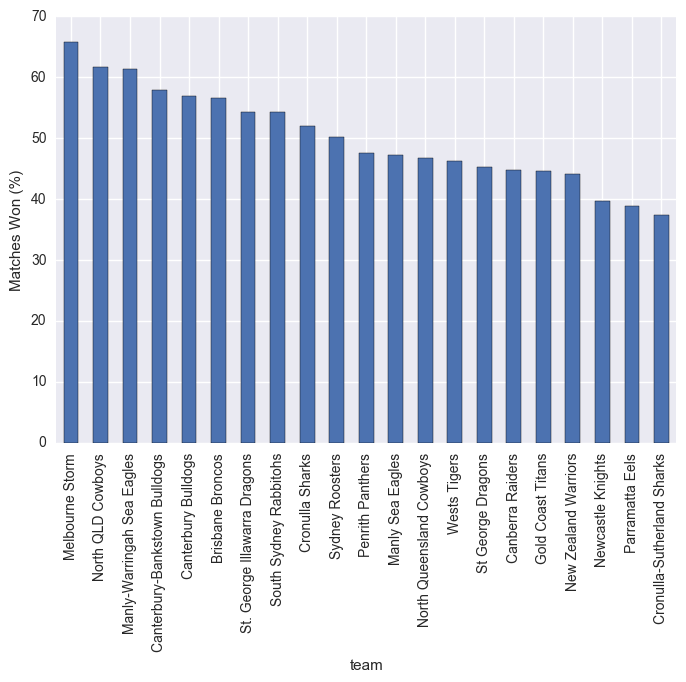

In [22]:
matches = get_matches()
stats = get_team_stats()
stats["matches_won_percent"].sort_values(ascending=False).plot(kind="bar")
plt.ylabel("Matches Won (%)")
plt.show()

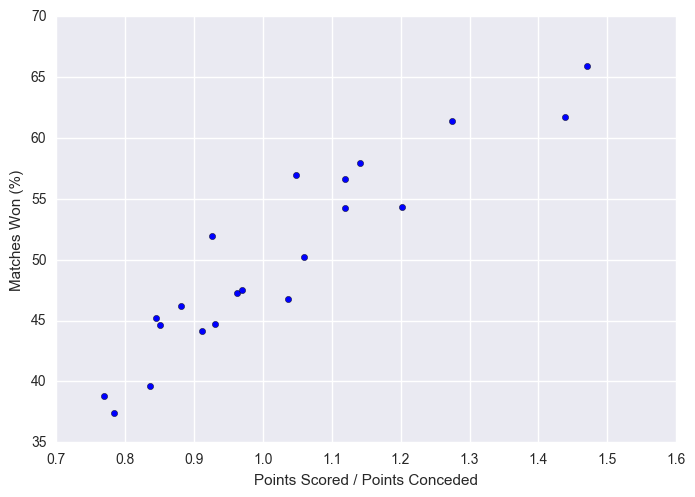

In [26]:
plt.scatter(x = stats["scored/conceded"], y = stats["matches_won_percent"])
plt.xlabel("Points Scored / Points Conceded")
plt.ylabel("Matches Won (%)")
plt.show()

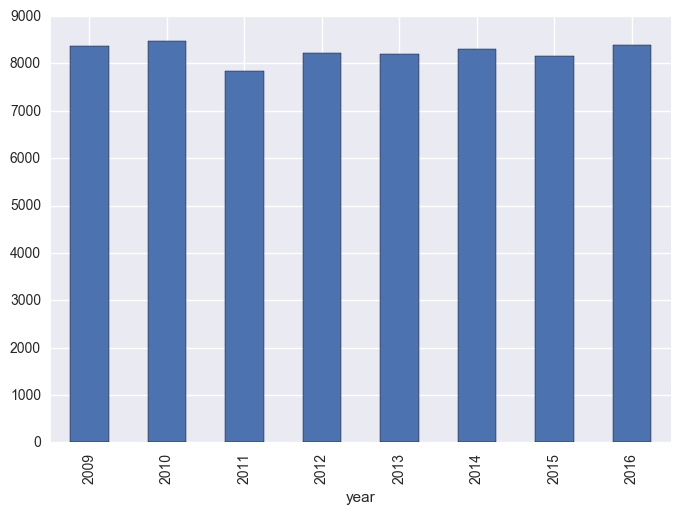

In [12]:
matches["total_scored"] = matches["score1"] + matches["score2"]
matches.groupby("year").sum()["total_scored"].plot(kind="bar")
plt.show()

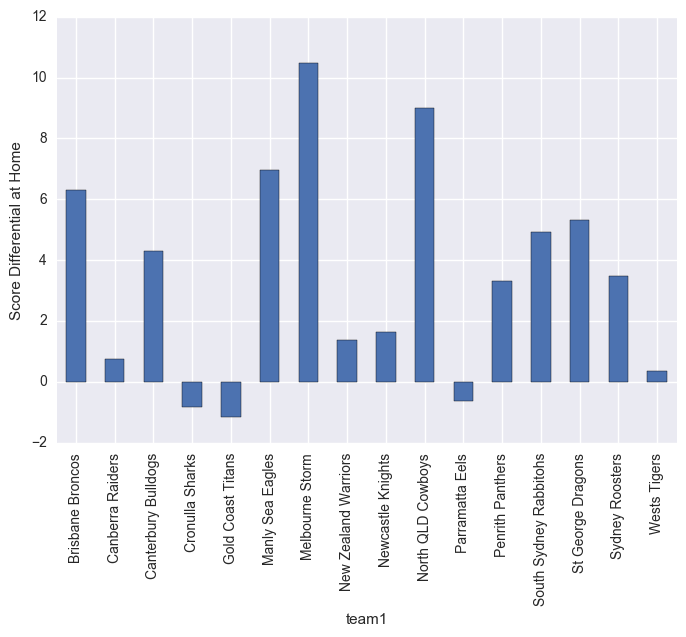

In [13]:
matches.groupby("team1").mean()["score_diff"].plot(kind="bar")
plt.ylabel("Score Differential at Home")
plt.show()

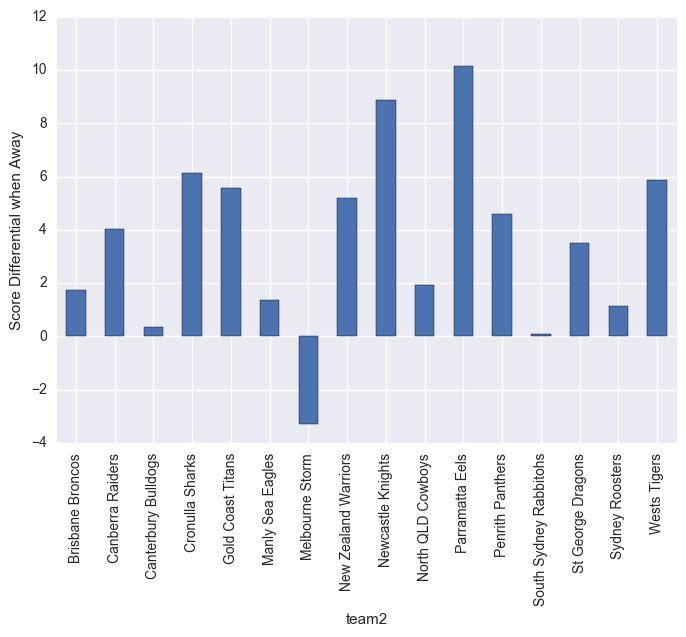

In [14]:
matches.groupby("team2").mean()["score_diff"].plot(kind="bar")
plt.ylabel("Score Differential when Away")
plt.show()

## 5. Prediction Definition
Given our previous indication, we'll now seek to apply some very basic, rudimentary machine learning techniques to see if we can beat a coin-flip at guessing the winner of a match.

In [9]:
def extract_samples(matches, origin_features, result_feature):
    inputs = [tuple(matches.loc[i, feature] for feature in origin_features) for i in matches.index]
    outputs = tuple(matches[result_feature].values)

    assert len(inputs) == len(outputs)
    
    return inputs, outputs

In [10]:
from sklearn.preprocessing import StandardScaler

def normalize(array):
    scaler = StandardScaler()
    array = scaler.fit_transform(array)

    return scaler, array

In [11]:
from random import random

def split_samples(inputs, outputs, percent=0.66):
    assert len(inputs) == len(outputs)

    inputs1 = []
    inputs2 = []
    outputs1 = []
    outputs2 = []

    for i, inputs_row in enumerate(inputs):
        if random() < percent:
            input_to = inputs1
            output_to = outputs1
        else:
            input_to = inputs2
            output_to = outputs2

        input_to.append(inputs_row)
        output_to.append(outputs[i])

    return inputs1, outputs1, inputs2, outputs2

In [37]:
input_features = ["year",
                  "matches_won_percent",
                  "podium_score_yearly",
                  "matches_won_percent_2",
                  "podium_score_yearly_2"]

output_feature = "winner"
matches = get_matches(with_team_stats=True)
inputs, outputs = extract_samples(matches, input_features, output_feature)
normalizer, inputs = normalize(inputs)

train_inputs, train_outputs, test_inputs, test_outputs = split_samples(inputs, outputs)


###### 6. Basic Models 

In [13]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score

In [14]:
k_fold = KFold(n_splits = 10)
clf = SVC()
clf.fit(train_inputs, train_outputs)
print("SVC Score: ",clf.score(test_inputs, test_outputs))

clf_forest = RandomForestClassifier(n_estimators=100)
clf_forest.fit(train_inputs, train_outputs)
print("Random Forest Score: ", clf_forest.score(test_inputs, test_outputs))

SVC Score:  0.57848324515
Random Forest Score:  0.567901234568


We see that our prediction model doesn't do that well, only just beating out a 50% probability. This premise is likely falling out from the lack of data available and the relatively small sample size being used.

## 8. Neural Nets

We can also explore the use of Keras here. We will use a very basic approach and give some demonstrative examples of how to apply Keras to this type of data.

In [38]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop, SGD
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import StratifiedKFold

In [51]:
X = np.array(inputs)
y = np.array(outputs).astype(float)
y[y == 2] = 0 # We treat 2 as a loss, 1 as a win. Normalise this so that 0 = loss, 1 = win.

kfold = StratifiedKFold(n_splits=10)
cvscores = []
history = []

In [52]:
for train, test in kfold.split(X, y):
  # create model
    model = Sequential()
    model.add(Dense(12, activation='relu',input_dim=len(input_features) ))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    opt = SGD(lr=0.01) 
    model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])
    # Fit the model
    history.append(model.fit(X[train], y[train], nb_epoch=20, batch_size=128, verbose=0))
    # evaluate the model
    scores = model.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

acc: 43.48%
acc: 58.39%
acc: 58.39%
acc: 59.01%
acc: 60.25%
acc: 57.14%
acc: 56.52%
acc: 54.04%
acc: 53.42%
acc: 58.49%


As expected, the results aren't significantly improved on what we obtained with SVC and RF. Rather, we see that we typically see results in the range of 50-60%. Using this validation, we can now fit a model and draw some conclusions.

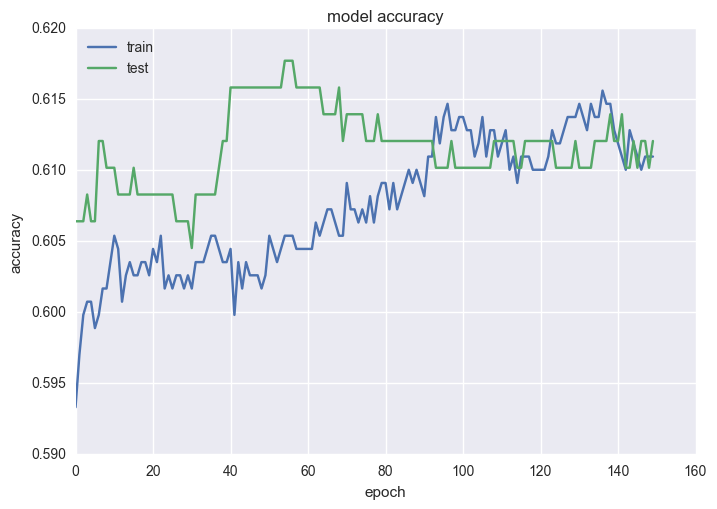

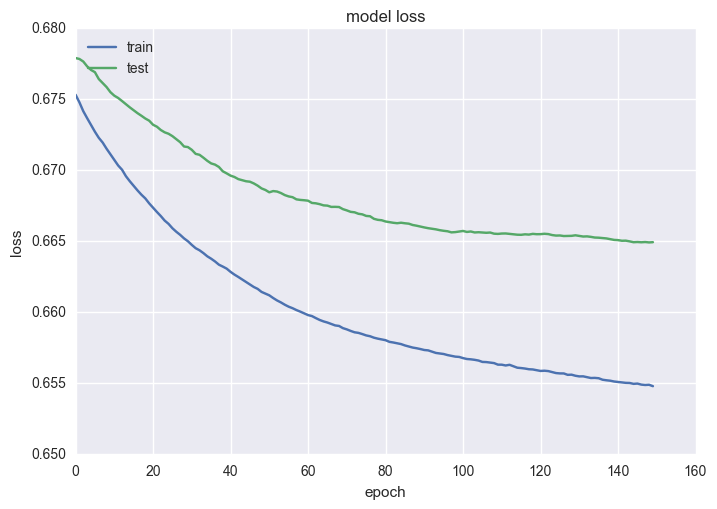

In [53]:
history = model.fit(X, y, validation_split=0.33, nb_epoch=150, batch_size=128, verbose=0)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_28 (Dense)                 (None, 12)            72          dense_input_10[0][0]             
____________________________________________________________________________________________________
dense_29 (Dense)                 (None, 8)             104         dense_28[0][0]                   
____________________________________________________________________________________________________
dense_30 (Dense)                 (None, 1)             9           dense_29[0][0]                   
Total params: 185
Trainable params: 185
Non-trainable params: 0
____________________________________________________________________________________________________


## 9. Application to Prediction


In [35]:
def predict(year, team1, team2):
    inputs = []
    
    for feature in input_features:
        from_team_2 = '_2' in feature
        feature = feature.replace('_2', '')
        
        if feature in stats.columns.values:
            team = team2 if from_team_2 else team1
            value = stats.loc[team, feature]
        elif feature == 'year':
            value = year
        else:
            raise ValueError("Don't know where to get feature: " + feature)
            
        inputs.append(value)
    
    inputs = np.array([normalizer.transform(inputs)])
    result = model.predict(inputs)
    
    if result == 0.5:
        return 'tie'
    elif result > 0.5:
        return team1
    elif result < 0.5:
        return team2
    else:
        return "Unknown result: " + str(result)
    
print(predict(2013,"Cronulla Sharks", "Melbourne Storm"))
print(predict(2015, "Penrith Panthers", "Sydney Roosters"))

Melbourne Storm
Sydney Roosters


## 10. Extra Areas to Explore
It's obvious that the implementations above are fairly basic, and are mainly just for showing how to apply the techniques. There are many extra areas to explore, particularly around feature analysis and understanding of what features would actually drive predictions. We could perhaps incorporate things like points scored ratios, average point differentials, number of representative level players etc. The largest gains would probably come from incorporating some of the betting statistics which are available, based on head-to-head odds.